In [1]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [3]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [4]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [5]:
BATCH_SIZE = 32

EPOCHS = 100

In [6]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [7]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-10]:
    layer.trainable = False

In [8]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [9]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.2)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [13]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 210 images belonging to 5 classes.


In [14]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [15]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [17]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/100
7/7 [==============================] - 43s 5s/step - loss: 2.6250 - accuracy: 0.2048 - val_loss: 2.5508 - val_accuracy: 0.2833
Epoch 2/100
7/7 [==============================] - 26s 4s/step - loss: 2.0371 - accuracy: 0.3095 - val_loss: 2.7348 - val_accuracy: 0.2333
Epoch 3/100
7/7 [==============================] - 25s 4s/step - loss: 2.1049 - accuracy: 0.2905 - val_loss: 2.0727 - val_accuracy: 0.3500
Epoch 4/100
7/7 [==============================] - 25s 4s/step - loss: 2.0444 - accuracy: 0.3381 - val_loss: 2.1833 - val_accuracy: 0.4333
Epoch 5/100
7/7 [==============================] - 27s 4s/step - loss: 1.6868 - accuracy: 0.4333 - val_loss: 1.9476 - val_accuracy: 0.3667
Epoch 6/100
7/7 [==============================] - 26s 4s/step - loss: 1.6904 - accuracy: 0.4048 - val_loss: 1.9178 - val_accuracy: 0.3500
Epoch 7/100
7/7 [==============================] - 29s 4s/step - loss: 1.5338 - accuracy: 0.4714 - val_loss: 1.7415 - val_accuracy: 0.4833
Epoch 8/100
7/7 [==========

7/7 [==============================] - 27s 4s/step - loss: 0.5939 - accuracy: 0.7667 - val_loss: 0.7181 - val_accuracy: 0.7833
Epoch 60/100
7/7 [==============================] - 26s 4s/step - loss: 0.5522 - accuracy: 0.8000 - val_loss: 0.9532 - val_accuracy: 0.7000
Epoch 61/100
7/7 [==============================] - 27s 4s/step - loss: 0.4449 - accuracy: 0.8238 - val_loss: 0.6847 - val_accuracy: 0.8167
Epoch 62/100
7/7 [==============================] - 29s 4s/step - loss: 0.5722 - accuracy: 0.7810 - val_loss: 0.9143 - val_accuracy: 0.6500
Epoch 63/100
7/7 [==============================] - 27s 4s/step - loss: 0.6578 - accuracy: 0.7524 - val_loss: 0.7292 - val_accuracy: 0.7667
Epoch 64/100
7/7 [==============================] - 28s 4s/step - loss: 0.6298 - accuracy: 0.7571 - val_loss: 0.8876 - val_accuracy: 0.7000
Epoch 65/100
7/7 [==============================] - 28s 4s/step - loss: 0.5331 - accuracy: 0.8095 - val_loss: 0.7010 - val_accuracy: 0.6500
Epoch 66/100
7/7 [===============

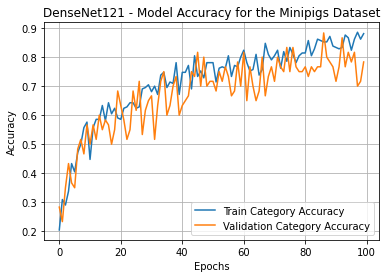

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

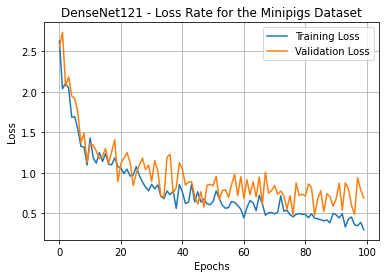

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 9s 269ms/step - loss: 0.8995 - accuracy: 0.6500

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\test

Training: 0.876, Validation: 0.650

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [21]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 4s 34ms/step - loss: 0.9467 - accuracy: 0.7429

Test loss and accuracy are: [0.9466747641563416, 0.7428571581840515]


In [22]:
model.save('model_-10_0.2_100Epochs_v2.h5')


Predictions:

[[2.0511366e-02 9.6439618e-01 1.4558670e-02 5.0076316e-05 4.8370002e-04]
 [1.0267412e-04 3.2214640e-04 9.7020054e-01 2.5958338e-06 2.9372003e-02]
 [8.7521553e-01 1.2430749e-01 1.7450980e-04 2.5990454e-04 4.2540967e-05]
 [9.9637932e-01 3.1194007e-03 7.1774539e-06 2.8768074e-04 2.0637800e-04]
 [1.8074751e-03 9.7340217e-04 9.3974024e-01 2.6779222e-05 5.7452179e-02]
 [1.3599890e-04 9.9985564e-01 1.6415058e-07 8.0934906e-06 8.0157612e-08]
 [1.8125162e-06 1.0291673e-05 9.9444711e-01 2.6993741e-08 5.5408040e-03]
 [3.3059326e-01 9.0258932e-03 8.4684223e-05 6.4770710e-01 1.2589108e-02]
 [4.2985354e-04 9.9956053e-01 8.2050281e-07 8.3108444e-06 4.3964948e-07]
 [1.3132232e-04 2.4551956e-04 9.9915719e-01 1.0031117e-04 3.6565409e-04]
 [9.2345372e-02 2.4913577e-04 3.9172253e-01 6.6972119e-05 5.1561594e-01]
 [2.9764107e-01 6.9938630e-01 3.0440203e-04 3.8306833e-05 2.6299369e-03]
 [6.6392529e-01 3.3491504e-01 8.3047064e-04 2.6862381e-05 3.0225309e-04]
 [1.4996864e-01 3.1448632e-02 1.2831

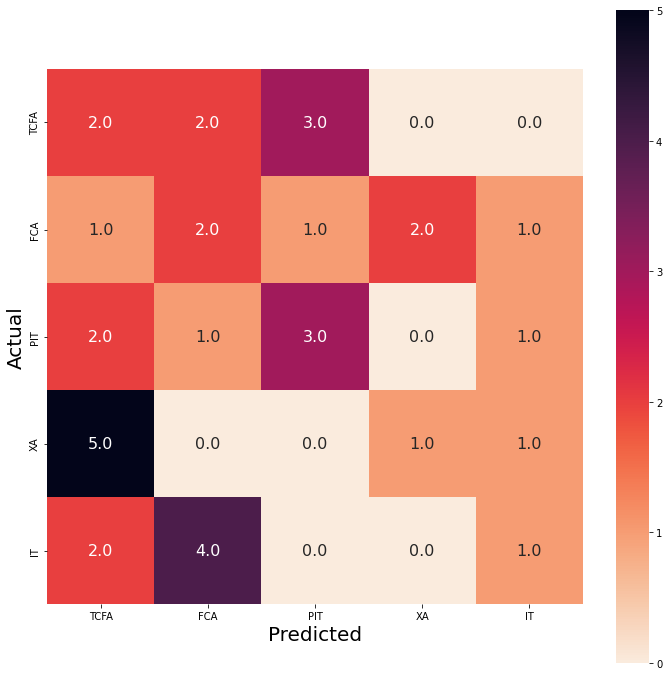

In [23]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

label = ['TCFA', 'FCA', 'PIT', 'XA', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()